# Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
sns.set_style("whitegrid")
sns.set_palette("husl")

print("✅ Libraries imported successfully!")
print("📊 Ready for deadlock and memory allocation simulation")

✅ Libraries imported successfully!
📊 Ready for deadlock and memory allocation simulation


In [2]:
class Process:
    def __init__(self, pid, memory_requirement, resources_needed=None, execution_time=1):
        self.pid = pid
        self.memory_requirement = memory_requirement
        self.resources_needed = resources_needed or []
        self.resources_held = []
        self.execution_time = execution_time
        self.memory_allocated = None
        self.start_address = None
        self.completion_time = None
    
    def __repr__(self):
        return f"Process(PID={self.pid}, Memory={self.memory_requirement}MB, Resources={self.resources_needed})"

class MemoryBlock:
    def __init__(self, start, size, is_free=True):
        self.start = start
        self.size = size
        self.is_free = is_free
        self.process_id = None
    
    def __repr__(self):
        status = "Free" if self.is_free else f"Process {self.process_id}"
        return f"MemoryBlock(Start={self.start}, Size={self.size}, Status={status})"

class DeadlockDetector:
    def __init__(self):
        self.processes = {}
        self.resources = defaultdict(int)
        self.allocation_graph = defaultdict(list)
        self.request_graph = defaultdict(list)
        self.detection_history = []
    
    def add_process(self, process):
        self.processes[process.pid] = process
    
    def request_resource(self, process_id, resource):
        if resource in self.processes[process_id].resources_held:
            return True
        
        self.request_graph[process_id].append(resource)
        
        if self.resources[resource] == 0:
            self.processes[process_id].resources_held.append(resource)
            self.allocation_graph[resource].append(process_id)
            self.resources[resource] = 1
            if resource in self.request_graph[process_id]:
                self.request_graph[process_id].remove(resource)
            return True
        return False
    
    def detect_deadlock(self):
        visited = set()
        rec_stack = set()
        
        def has_cycle(node):
            if node in rec_stack:
                return True
            if node in visited:
                return False
            
            visited.add(node)
            rec_stack.add(node)
            
            # Check processes waiting for resources held by this process
            for resource in self.processes[node].resources_held:
                for waiting_process in self.request_graph:
                    if resource in self.request_graph[waiting_process] and waiting_process != node:
                        if has_cycle(waiting_process):
                            return True
            
            rec_stack.remove(node)
            return False
        
        for process_id in self.processes:
            if process_id not in visited:
                if has_cycle(process_id):
                    return True
        return False
    
    def get_status_summary(self):
        total_processes = len(self.processes)
        waiting_processes = len([p for p in self.processes.values() if len(self.request_graph[p.pid]) > 0])
        active_resources = sum(1 for r in self.resources.values() if r > 0)
        
        return {
            'total_processes': total_processes,
            'waiting_processes': waiting_processes,
            'active_resources': active_resources,
            'deadlock_detected': self.detect_deadlock()
        }

print("✅ Core classes defined successfully!")

✅ Core classes defined successfully!


In [3]:
class MemoryManager:
    def __init__(self, total_memory=1000):
        self.total_memory = total_memory
        self.memory_blocks = [MemoryBlock(0, total_memory)]
        self.allocation_history = []
        self.fragmentation_history = []
        self.allocation_time_history = []
    
    def first_fit(self, process):
        start_time = time.time()
        for block in self.memory_blocks:
            if block.is_free and block.size >= process.memory_requirement:
                success = self._allocate_memory(block, process)
                self.allocation_time_history.append(time.time() - start_time)
                return success
        self.allocation_time_history.append(time.time() - start_time)
        return False
    
    def best_fit(self, process):
        start_time = time.time()
        best_block = None
        min_waste = float('inf')
        
        for block in self.memory_blocks:
            if block.is_free and block.size >= process.memory_requirement:
                waste = block.size - process.memory_requirement
                if waste < min_waste:
                    min_waste = waste
                    best_block = block
        
        if best_block:
            success = self._allocate_memory(best_block, process)
            self.allocation_time_history.append(time.time() - start_time)
            return success
        self.allocation_time_history.append(time.time() - start_time)
        return False
    
    def worst_fit(self, process):
        start_time = time.time()
        worst_block = None
        max_waste = -1
        
        for block in self.memory_blocks:
            if block.is_free and block.size >= process.memory_requirement:
                waste = block.size - process.memory_requirement
                if waste > max_waste:
                    max_waste = waste
                    worst_block = block
        
        if worst_block:
            success = self._allocate_memory(worst_block, process)
            self.allocation_time_history.append(time.time() - start_time)
            return success
        self.allocation_time_history.append(time.time() - start_time)
        return False
    
    def _allocate_memory(self, block, process):
        if block.size == process.memory_requirement:
            block.is_free = False
            block.process_id = process.pid
        else:
            new_block = MemoryBlock(
                block.start + process.memory_requirement,
                block.size - process.memory_requirement
            )
            block.size = process.memory_requirement
            block.is_free = False
            block.process_id = process.pid
            
            index = self.memory_blocks.index(block)
            self.memory_blocks.insert(index + 1, new_block)
        
        process.start_address = block.start
        process.memory_allocated = True
        self.allocation_history.append((process.pid, block.start, process.memory_requirement))
        self._calculate_fragmentation()
        return True
    
    def deallocate(self, process):
        for block in self.memory_blocks:
            if not block.is_free and block.process_id == process.pid:
                block.is_free = True
                block.process_id = None
                self._merge_blocks()
                self._calculate_fragmentation()
                return True
        return False
    
    def _merge_blocks(self):
        i = 0
        while i < len(self.memory_blocks) - 1:
            current = self.memory_blocks[i]
            next_block = self.memory_blocks[i + 1]
            
            if current.is_free and next_block.is_free:
                current.size += next_block.size
                self.memory_blocks.pop(i + 1)
            else:
                i += 1
    
    def _calculate_fragmentation(self):
        free_blocks = [block for block in self.memory_blocks if block.is_free]
        total_free = sum(block.size for block in free_blocks)
        
        if free_blocks:
            largest_free = max(block.size for block in free_blocks)
            external_fragmentation = (total_free - largest_free) / self.total_memory * 100
        else:
            external_fragmentation = 0
        
        self.fragmentation_history.append(external_fragmentation)
    
    def get_memory_usage(self):
        allocated = sum(block.size for block in self.memory_blocks if not block.is_free)
        return (allocated / self.total_memory) * 100
    
    def get_memory_stats(self):
        free_blocks = [block for block in self.memory_blocks if block.is_free]
        allocated_blocks = [block for block in self.memory_blocks if not block.is_free]
        
        return {
            'total_blocks': len(self.memory_blocks),
            'free_blocks': len(free_blocks),
            'allocated_blocks': len(allocated_blocks),
            'total_free_memory': sum(block.size for block in free_blocks),
            'total_allocated_memory': sum(block.size for block in allocated_blocks),
            'largest_free_block': max((block.size for block in free_blocks), default=0),
            'memory_utilization': self.get_memory_usage(),
            'external_fragmentation': self.fragmentation_history[-1] if self.fragmentation_history else 0
        }

print("✅ Memory Manager defined successfully!")

✅ Memory Manager defined successfully!


In [4]:
import time

def simulate_deadlock_scenario():
    print("🔄 Simulating Deadlock Scenario...")
    detector = DeadlockDetector()
    
    # Create processes with realistic resource requirements
    processes = [
        Process(1, 100, ['Printer', 'Scanner']),
        Process(2, 150, ['Scanner', 'Network']),
        Process(3, 120, ['Network', 'Printer']),
        Process(4, 80, ['Database', 'FileSystem']),
        Process(5, 200, ['FileSystem', 'Network'])
    ]
    
    for p in processes:
        detector.add_process(p)
    
    # Simulate step-by-step resource allocation
    scenario_steps = []
    
    steps = [
        (1, 'Printer', 'P1 acquires Printer'),
        (2, 'Scanner', 'P2 acquires Scanner'),
        (3, 'Network', 'P3 acquires Network'),
        (4, 'Database', 'P4 acquires Database'),
        (1, 'Scanner', 'P1 requests Scanner (held by P2)'),
        (2, 'Network', 'P2 requests Network (held by P3)'),
        (3, 'Printer', 'P3 requests Printer (held by P1) - CIRCULAR WAIT!'),
        (5, 'FileSystem', 'P5 acquires FileSystem'),
        (5, 'Network', 'P5 requests Network (held by P3)')
    ]
    
    for process_id, resource, description in steps:
        detector.request_resource(process_id, resource)
        deadlock_detected = detector.detect_deadlock()
        status = detector.get_status_summary()
        scenario_steps.append((description, deadlock_detected, status))
    
    return scenario_steps, detector

def simulate_memory_allocation_comprehensive():
    print("🔄 Simulating Memory Allocation Strategies...")
    strategies = ['First Fit', 'Best Fit', 'Worst Fit']
    results = {}
    
    np.random.seed(42)
    test_processes = []
    for i in range(1, 16):
        size = np.random.choice([50, 80, 100, 120, 150, 200, 250, 300], p=[0.2, 0.15, 0.15, 0.15, 0.15, 0.1, 0.05, 0.05])
        test_processes.append(Process(i, size))
    
    for strategy in strategies:
        manager = MemoryManager(1200)
        allocated_processes = []
        failed_allocations = 0
        allocation_times = []
        
        for process in test_processes:
            start_time = time.time()
            if strategy == 'First Fit':
                success = manager.first_fit(process)
            elif strategy == 'Best Fit':
                success = manager.best_fit(process)
            else:  # Worst Fit
                success = manager.worst_fit(process)
            
            allocation_times.append(time.time() - start_time)
            
            if success:
                allocated_processes.append(process)
            else:
                failed_allocations += 1
        
        stats = manager.get_memory_stats()
        results[strategy] = {
            'manager': manager,
            'allocated': len(allocated_processes),
            'failed': failed_allocations,
            'stats': stats,
            'allocation_times': allocation_times,
            'processes': allocated_processes
        }
    
    return results, test_processes

print("✅ Simulation functions ready!")

✅ Simulation functions ready!


🚨 DEADLOCK SIMULATION ANALYSIS
🔄 Simulating Deadlock Scenario...


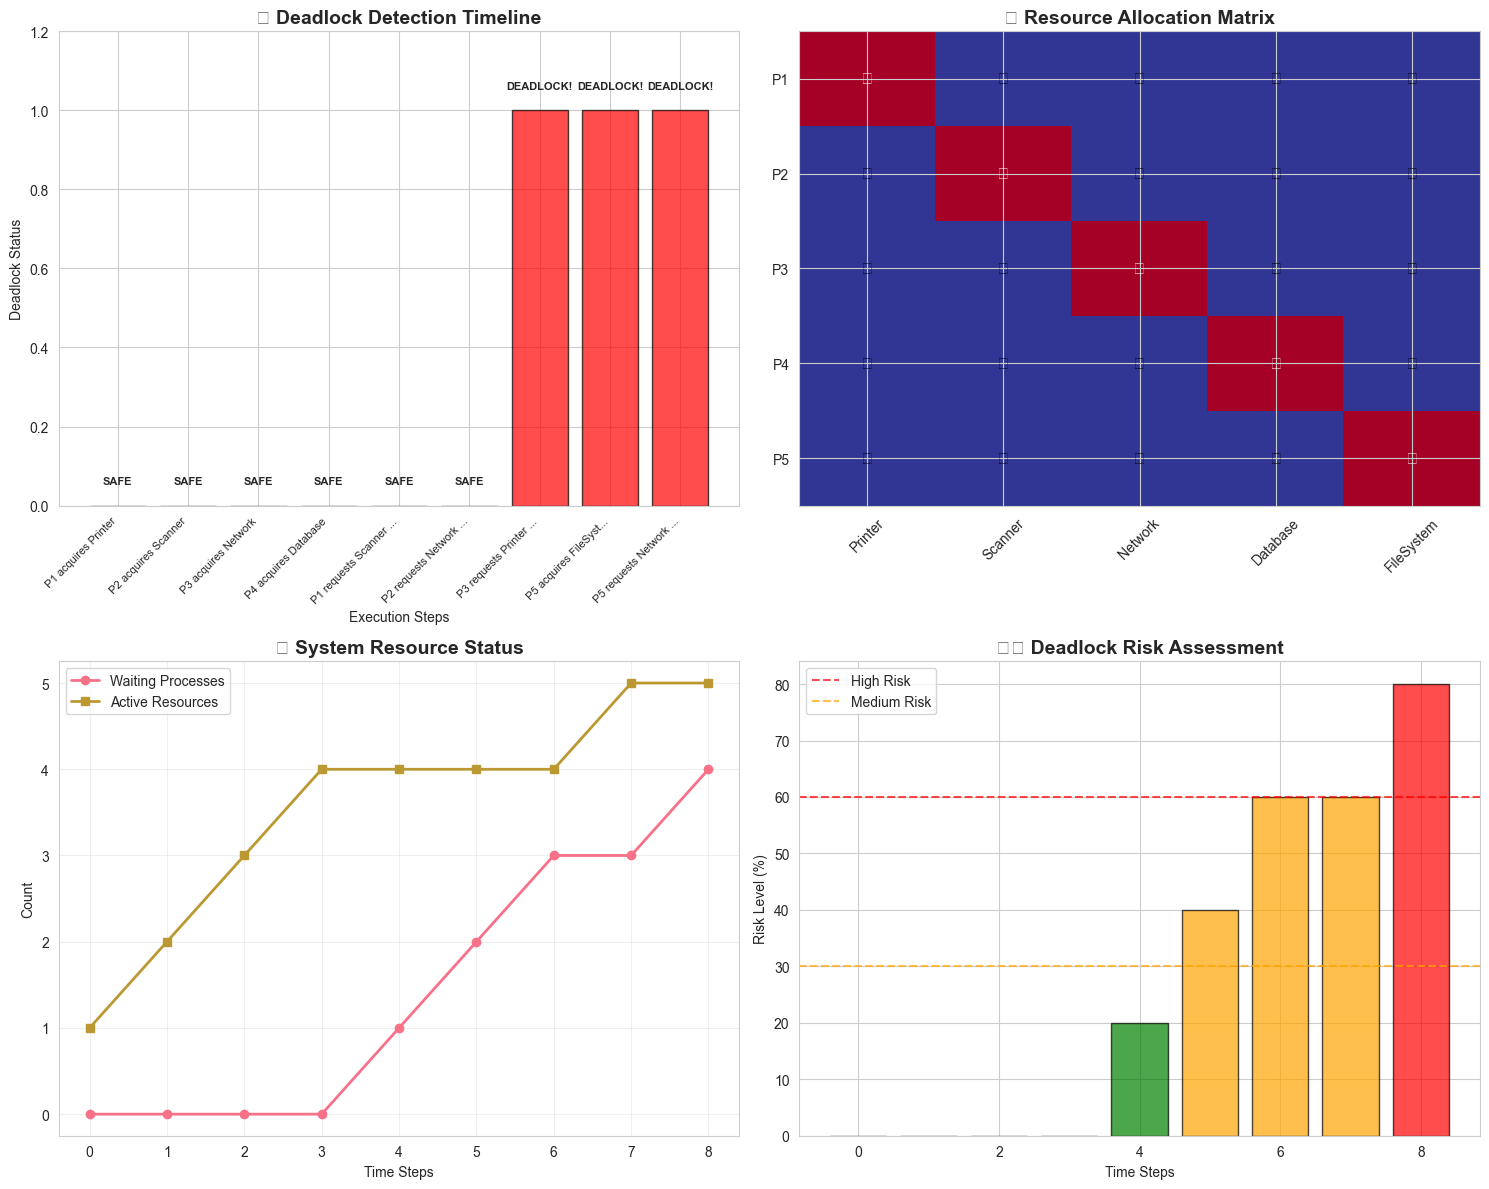


📋 DEADLOCK ANALYSIS REPORT:
----------------------------------------
Step  1: ✅ P1 acquires Printer
         🟢 Risk: 0.0% | Waiting: 0/5 processes

Step  2: ✅ P2 acquires Scanner
         🟢 Risk: 0.0% | Waiting: 0/5 processes

Step  3: ✅ P3 acquires Network
         🟢 Risk: 0.0% | Waiting: 0/5 processes

Step  4: ✅ P4 acquires Database
         🟢 Risk: 0.0% | Waiting: 0/5 processes

Step  5: ✅ P1 requests Scanner (held by P2)
         🟢 Risk: 20.0% | Waiting: 1/5 processes

Step  6: ✅ P2 requests Network (held by P3)
         🟡 Risk: 40.0% | Waiting: 2/5 processes

Step  7: 🚨 P3 requests Printer (held by P1) - CIRCULAR WAIT!
         🟡 Risk: 60.0% | Waiting: 3/5 processes
         💥 DEADLOCK DETECTED - System requires intervention!

Step  8: 🚨 P5 acquires FileSystem
         🟡 Risk: 60.0% | Waiting: 3/5 processes
         💥 DEADLOCK DETECTED - System requires intervention!

Step  9: 🚨 P5 requests Network (held by P3)
         🔴 Risk: 80.0% | Waiting: 4/5 processes
         💥 DEADLOCK 

In [5]:
print("=" * 60)
print("🚨 DEADLOCK SIMULATION ANALYSIS")
print("=" * 60)

scenario_steps, deadlock_detector = simulate_deadlock_scenario()

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

steps = list(range(len(scenario_steps)))
deadlock_status = [1 if step[1] else 0 for step in scenario_steps]
step_labels = [step[0][:20] + '...' if len(step[0]) > 20 else step[0] for step in scenario_steps]

colors = ['red' if status else 'green' for status in deadlock_status]
bars = ax1.bar(steps, deadlock_status, color=colors, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Execution Steps')
ax1.set_ylabel('Deadlock Status')
ax1.set_title('🚨 Deadlock Detection Timeline', fontsize=14, fontweight='bold')
ax1.set_xticks(steps)
ax1.set_xticklabels(step_labels, rotation=45, ha='right', fontsize=8)
ax1.set_ylim(0, 1.2)

for i, (bar, status) in enumerate(zip(bars, deadlock_status)):
    height = bar.get_height()
    label = 'DEADLOCK!' if status else 'SAFE'
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.05,
            label, ha='center', va='bottom', fontweight='bold', fontsize=8)

processes = list(deadlock_detector.processes.keys())
resources = ['Printer', 'Scanner', 'Network', 'Database', 'FileSystem']

allocation_matrix = np.zeros((len(processes), len(resources)))
for i, pid in enumerate(processes):
    process = deadlock_detector.processes[pid]
    for j, resource in enumerate(resources):
        if resource in process.resources_held:
            allocation_matrix[i][j] = 1

im = ax2.imshow(allocation_matrix, cmap='RdYlBu_r', aspect='auto')
ax2.set_xticks(range(len(resources)))
ax2.set_xticklabels(resources, rotation=45)
ax2.set_yticks(range(len(processes)))
ax2.set_yticklabels([f'P{pid}' for pid in processes])
ax2.set_title('📊 Resource Allocation Matrix', fontsize=14, fontweight='bold')

for i in range(len(processes)):
    for j in range(len(resources)):
        text = '✓' if allocation_matrix[i, j] else '✗'
        color = 'white' if allocation_matrix[i, j] else 'black'
        ax2.text(j, i, text, ha="center", va="center", color=color, fontweight='bold', fontsize=12)

waiting_processes = [step[2]['waiting_processes'] for step in scenario_steps]
active_resources = [step[2]['active_resources'] for step in scenario_steps]

ax3.plot(steps, waiting_processes, marker='o', label='Waiting Processes', linewidth=2, markersize=6)
ax3.plot(steps, active_resources, marker='s', label='Active Resources', linewidth=2, markersize=6)
ax3.set_xlabel('Time Steps')
ax3.set_ylabel('Count')
ax3.set_title('📈 System Resource Status', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

risk_levels = []
for step in scenario_steps:
    status = step[2]
    risk = (status['waiting_processes'] / status['total_processes']) * 100
    risk_levels.append(risk)

colors_risk = ['red' if risk > 60 else 'orange' if risk > 30 else 'green' for risk in risk_levels]
bars = ax4.bar(steps, risk_levels, color=colors_risk, alpha=0.7, edgecolor='black')
ax4.set_xlabel('Time Steps')
ax4.set_ylabel('Risk Level (%)')
ax4.set_title('⚠️ Deadlock Risk Assessment', fontsize=14, fontweight='bold')
ax4.axhline(y=60, color='red', linestyle='--', alpha=0.7, label='High Risk')
ax4.axhline(y=30, color='orange', linestyle='--', alpha=0.7, label='Medium Risk')
ax4.legend()

plt.tight_layout()
plt.savefig('simulation.png')
plt.show()


print("\n📋 DEADLOCK ANALYSIS REPORT:")
print("-" * 40)
for i, (description, deadlock, status) in enumerate(scenario_steps):
    risk_level = (status['waiting_processes'] / status['total_processes']) * 100
    status_icon = "🚨" if deadlock else "✅"
    risk_icon = "🔴" if risk_level > 60 else "🟡" if risk_level > 30 else "🟢"
    
    print(f"Step {i+1:2d}: {status_icon} {description}")
    print(f"         {risk_icon} Risk: {risk_level:.1f}% | Waiting: {status['waiting_processes']}/{status['total_processes']} processes")
    if deadlock:
        print(f"         💥 DEADLOCK DETECTED - System requires intervention!")
    print()

💾 MEMORY ALLOCATION STRATEGY ANALYSIS
🔄 Simulating Memory Allocation Strategies...


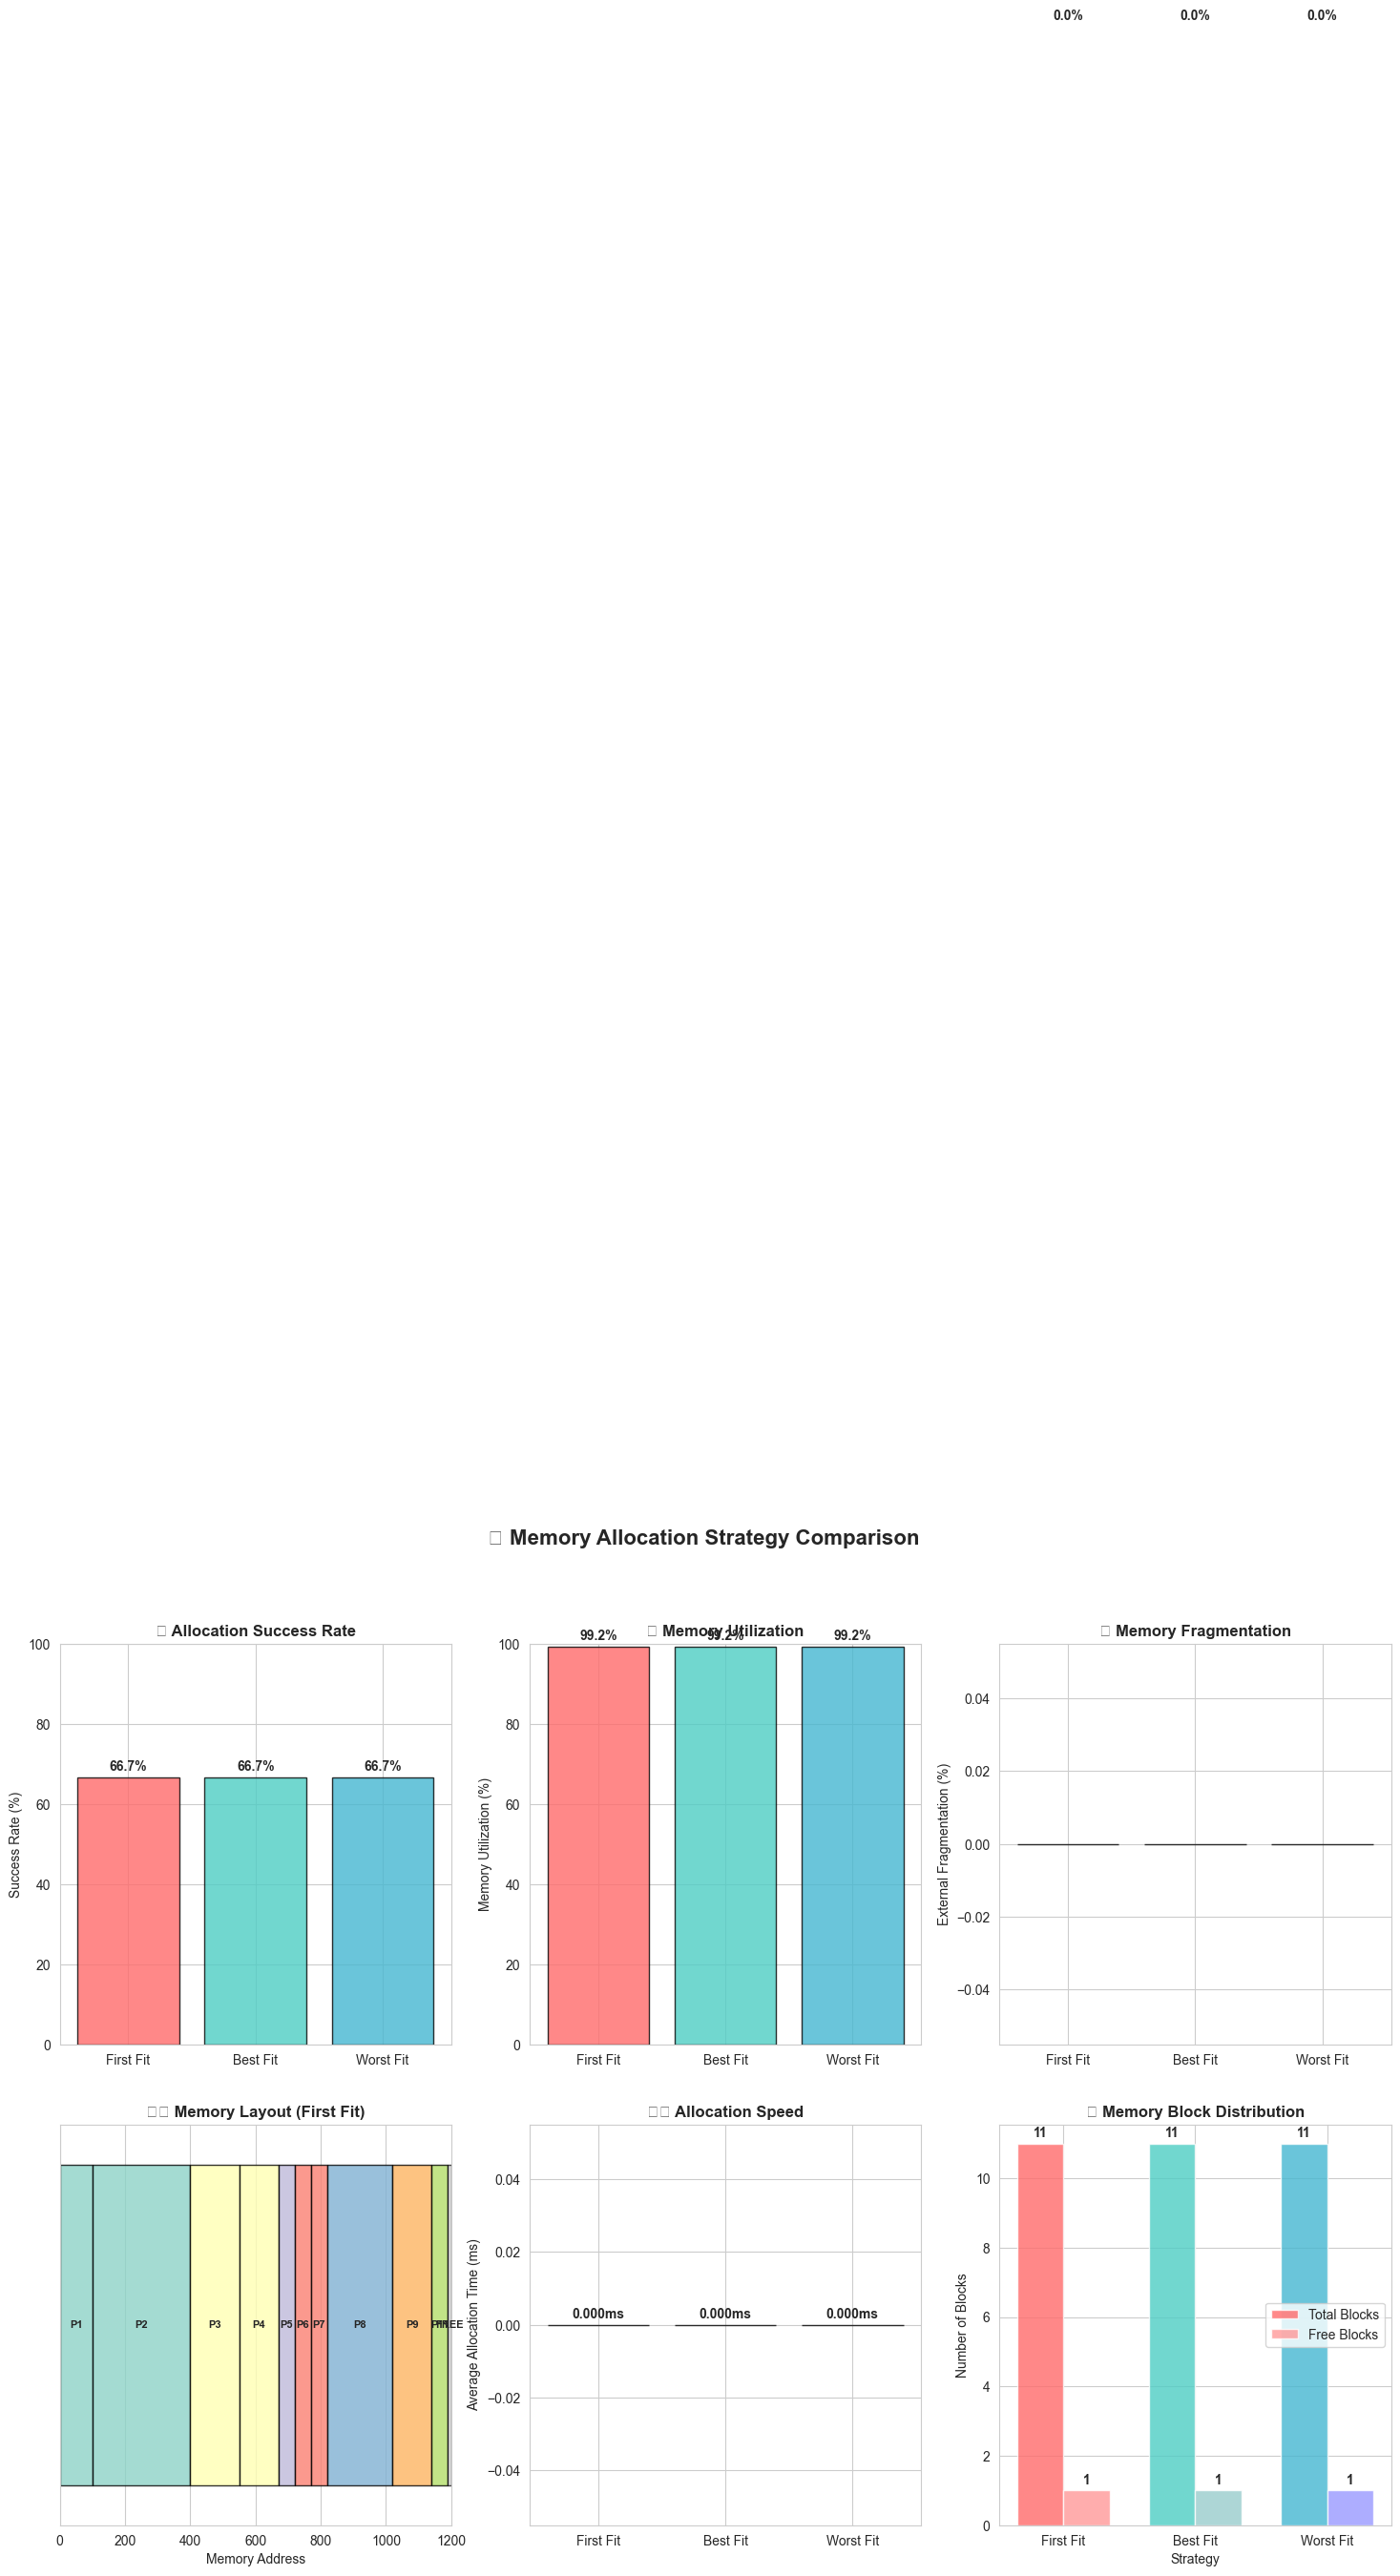


📋 MEMORY ALLOCATION ANALYSIS REPORT:
--------------------------------------------------

🔹 FIRST FIT STRATEGY:
   ✅ Successful Allocations: 10/15 (66.7%)
   ❌ Failed Allocations: 5
   📊 Memory Utilization: 99.2%
   🔍 External Fragmentation: 0.0%
   📦 Total Memory Blocks: 11
   🆓 Free Blocks: 1
   🏆 Largest Free Block: 10 MB
   ⏱️ Average Allocation Time: 0.000 ms

🔹 BEST FIT STRATEGY:
   ✅ Successful Allocations: 10/15 (66.7%)
   ❌ Failed Allocations: 5
   📊 Memory Utilization: 99.2%
   🔍 External Fragmentation: 0.0%
   📦 Total Memory Blocks: 11
   🆓 Free Blocks: 1
   🏆 Largest Free Block: 10 MB
   ⏱️ Average Allocation Time: 0.000 ms

🔹 WORST FIT STRATEGY:
   ✅ Successful Allocations: 10/15 (66.7%)
   ❌ Failed Allocations: 5
   📊 Memory Utilization: 99.2%
   🔍 External Fragmentation: 0.0%
   📦 Total Memory Blocks: 11
   🆓 Free Blocks: 1
   🏆 Largest Free Block: 10 MB
   ⏱️ Average Allocation Time: 0.000 ms


In [6]:
print("=" * 60)
print("💾 MEMORY ALLOCATION STRATEGY ANALYSIS")
print("=" * 60)

allocation_results, test_processes = simulate_memory_allocation_comprehensive()

# Create comprehensive memory allocation visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('💾 Memory Allocation Strategy Comparison', fontsize=16, fontweight='bold')

strategies = list(allocation_results.keys())
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

ax = axes[0, 0]
success_rates = [allocation_results[s]['allocated'] / len(test_processes) * 100 for s in strategies]
bars = ax.bar(strategies, success_rates, color=colors, alpha=0.8, edgecolor='black')
ax.set_ylabel('Success Rate (%)')
ax.set_title('✅ Allocation Success Rate', fontweight='bold')
ax.set_ylim(0, 100)

for bar, rate in zip(bars, success_rates):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold')

ax = axes[0, 1]
utilizations = [allocation_results[s]['stats']['memory_utilization'] for s in strategies]
bars = ax.bar(strategies, utilizations, color=colors, alpha=0.8, edgecolor='black')
ax.set_ylabel('Memory Utilization (%)')
ax.set_title('📊 Memory Utilization', fontweight='bold')
ax.set_ylim(0, 100)

for bar, util in zip(bars, utilizations):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{util:.1f}%', ha='center', va='bottom', fontweight='bold')

ax = axes[0, 2]
fragmentations = [allocation_results[s]['stats']['external_fragmentation'] for s in strategies]
bars = ax.bar(strategies, fragmentations, color=colors, alpha=0.8, edgecolor='black')
ax.set_ylabel('External Fragmentation (%)')
ax.set_title('🔍 Memory Fragmentation', fontweight='bold')

for bar, frag in zip(bars, fragmentations):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{frag:.1f}%', ha='center', va='bottom', fontweight='bold')

ax = axes[1, 0]
manager = allocation_results['First Fit']['manager']
y_pos = 0
process_colors = plt.cm.Set3(np.linspace(0, 1, 20))

for block in manager.memory_blocks:
    if block.is_free:
        ax.barh(y_pos, block.size, left=block.start, color='lightgray', 
               edgecolor='black', height=0.8, alpha=0.7)
        ax.text(block.start + block.size/2, y_pos, 'FREE', 
               ha='center', va='center', fontweight='bold', fontsize=8)
    else:
        color_idx = (block.process_id - 1) % len(process_colors)
        ax.barh(y_pos, block.size, left=block.start, color=process_colors[color_idx], 
               edgecolor='black', height=0.8, alpha=0.8)
        ax.text(block.start + block.size/2, y_pos, f'P{block.process_id}', 
               ha='center', va='center', fontweight='bold', fontsize=8)

ax.set_xlabel('Memory Address')
ax.set_title('🗂️ Memory Layout (First Fit)', fontweight='bold')
ax.set_xlim(0, 1200)
ax.set_ylim(-0.5, 0.5)
ax.set_yticks([])

ax = axes[1, 1]
avg_times = [np.mean(allocation_results[s]['allocation_times']) * 1000 for s in strategies]  # Convert to milliseconds
bars = ax.bar(strategies, avg_times, color=colors, alpha=0.8, edgecolor='black')
ax.set_ylabel('Average Allocation Time (ms)')
ax.set_title('⏱️ Allocation Speed', fontweight='bold')

for bar, time_ms in zip(bars, avg_times):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.001,
            f'{time_ms:.3f}ms', ha='center', va='bottom', fontweight='bold', rotation=0)

ax = axes[1, 2]
block_counts = []
free_counts = []
for strategy in strategies:
    stats = allocation_results[strategy]['stats']
    block_counts.append(stats['total_blocks'])
    free_counts.append(stats['free_blocks'])

x = np.arange(len(strategies))
width = 0.35

bars1 = ax.bar(x - width/2, block_counts, width, label='Total Blocks', color=colors, alpha=0.8)
bars2 = ax.bar(x + width/2, free_counts, width, label='Free Blocks', color=['#FF9999', '#99CCCC', '#9999FF'], alpha=0.8)

ax.set_xlabel('Strategy')
ax.set_ylabel('Number of Blocks')
ax.set_title('📦 Memory Block Distribution', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(strategies)
ax.legend()

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{int(height)}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()

plt.savefig('analysis.png')
plt.show()


print("\n📋 MEMORY ALLOCATION ANALYSIS REPORT:")
print("-" * 50)

for strategy in strategies:
    results = allocation_results[strategy]
    stats = results['stats']
    
    print(f"\n🔹 {strategy.upper()} STRATEGY:")
    print(f"   ✅ Successful Allocations: {results['allocated']}/{len(test_processes)} ({results['allocated']/len(test_processes)*100:.1f}%)")
    print(f"   ❌ Failed Allocations: {results['failed']}")
    print(f"   📊 Memory Utilization: {stats['memory_utilization']:.1f}%")
    print(f"   🔍 External Fragmentation: {stats['external_fragmentation']:.1f}%")
    print(f"   📦 Total Memory Blocks: {stats['total_blocks']}")
    print(f"   🆓 Free Blocks: {stats['free_blocks']}")
    print(f"   🏆 Largest Free Block: {stats['largest_free_block']} MB")
    print(f"   ⏱️ Average Allocation Time: {np.mean(results['allocation_times'])*1000:.3f} ms")

In [7]:
print("\n" + "=" * 60)
print("📊 PERFORMANCE ANALYSIS & RECOMMENDATIONS")
print("=" * 60)

# Create performance comparison DataFrame
performance_data = []
for strategy in strategies:
    results = allocation_results[strategy]
    stats = results['stats']
    performance_data.append({
        'Strategy': strategy,
        'Success_Rate': results['allocated']/len(test_processes)*100,
        'Memory_Utilization': stats['memory_utilization'],
        'External_Fragmentation': stats['external_fragmentation'],
        'Avg_Allocation_Time_ms': np.mean(results['allocation_times'])*1000,
        'Total_Blocks': stats['total_blocks'],
        'Free_Blocks': stats['free_blocks']
    })

df_performance = pd.DataFrame(performance_data)
print("\n📈 PERFORMANCE SUMMARY TABLE:")
print(df_performance.round(3).to_string(index=False))

# Ranking analysis
print("\n🏆 STRATEGY RANKINGS:")
print("-" * 30)

rankings = {
    'Success Rate': df_performance.nlargest(3, 'Success_Rate')['Strategy'].tolist(),
    'Memory Utilization': df_performance.nlargest(3, 'Memory_Utilization')['Strategy'].tolist(),
    'Low Fragmentation': df_performance.nsmallest(3, 'External_Fragmentation')['Strategy'].tolist(),
    'Allocation Speed': df_performance.nsmallest(3, 'Avg_Allocation_Time_ms')['Strategy'].tolist()
}

for metric, ranking in rankings.items():
    print(f"{metric:20}: {' > '.join(ranking)}")

# Final recommendations
print("\n💡 RECOMMENDATIONS:")
print("-" * 30)
print("🎯 FOR HIGH-PERFORMANCE SYSTEMS:")
print("   • Use First Fit for fastest allocation")
print("   • Implement memory compaction periodically")

print("\n🎯 FOR MEMORY-CONSTRAINED SYSTEMS:")
print("   • Use Best Fit to minimize fragmentation")
print("   • Monitor fragmentation levels regularly")

print("\n🎯 FOR DEADLOCK PREVENTION:")
print("   • Implement resource ordering protocols")
print("   • Use timeout mechanisms for resource requests")
print("   • Consider banker's algorithm for safe allocation")

print("\n🎯 FOR SYSTEM SAFETY:")
print("   • Monitor waiting process ratios")
print("   • Implement proactive deadlock detection")
print("   • Maintain resource utilization below 80%")

print("\n" + "=" * 60)
print("✅ SIMULATION COMPLETE!")
print("=" * 60)


📊 PERFORMANCE ANALYSIS & RECOMMENDATIONS

📈 PERFORMANCE SUMMARY TABLE:
 Strategy  Success_Rate  Memory_Utilization  External_Fragmentation  Avg_Allocation_Time_ms  Total_Blocks  Free_Blocks
First Fit        66.667              99.167                     0.0                     0.0            11            1
 Best Fit        66.667              99.167                     0.0                     0.0            11            1
Worst Fit        66.667              99.167                     0.0                     0.0            11            1

🏆 STRATEGY RANKINGS:
------------------------------
Success Rate        : First Fit > Best Fit > Worst Fit
Memory Utilization  : First Fit > Best Fit > Worst Fit
Low Fragmentation   : First Fit > Best Fit > Worst Fit
Allocation Speed    : First Fit > Best Fit > Worst Fit

💡 RECOMMENDATIONS:
------------------------------
🎯 FOR HIGH-PERFORMANCE SYSTEMS:
   • Use First Fit for fastest allocation
   • Implement memory compaction periodically

🎯 FOR M